In [1]:
#https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/

#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/006%20Time%20Series%20Forecasting%20-%20Multi-Output%20Regression.ipynb

# Step #1 Load the Data

In [3]:
# Time Series Forecasting - Multi-output Regression for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
import time
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data

import tensorflow as tf
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training


import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
 
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.callbacks import EarlyStopping
# from keras.layers import Flatten,Dropout    
    
import seaborn as sns


# check the tensorflow version and the number of available GPUs
# print('Tensorflow Version: ' + tf.__version__)
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Num GPUs:", len(physical_devices))



In [4]:
ab_path = "../data/SET50-Daily-Y09-Now.csv"
stockname='SET50'

start_date='2016-01-01'
end_date='2022-12-31'

date_col='Date'
prediction_col='EMA1'
# feature_cols=['Price','EMA1','MACD','RSI']
feature_cols=['EMA1']

my_model_loss='mean_absolute_error'
my_model_metrics=[my_model_loss]
my_obj_tune="mae"

split_way=1

input_sequence_length =60
output_sequence_length =10
train_ratio=0.8

n_epochs = 100
n_batch_size = 32
n_early=6



tune_folder='multivar_set50_final'

seed=98

In [109]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)
allCols=list(df.columns)
print(allCols)

['Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']


In [110]:
df[date_col]=df[date_col].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date,:]
df=df[feature_cols]
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2680 entries, 2012-01-04 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA2    2680 non-null   float64
dtypes: float64(1)
memory usage: 41.9 KB
None


,EMA2
Date,
2022-12-26,980.65
2022-12-27,982.12
2022-12-28,983.87
2022-12-29,986.38
2022-12-30,988.17


# Step #2 Exploring the Data

In [111]:
ncols = 1
nrows = len(feature_cols)

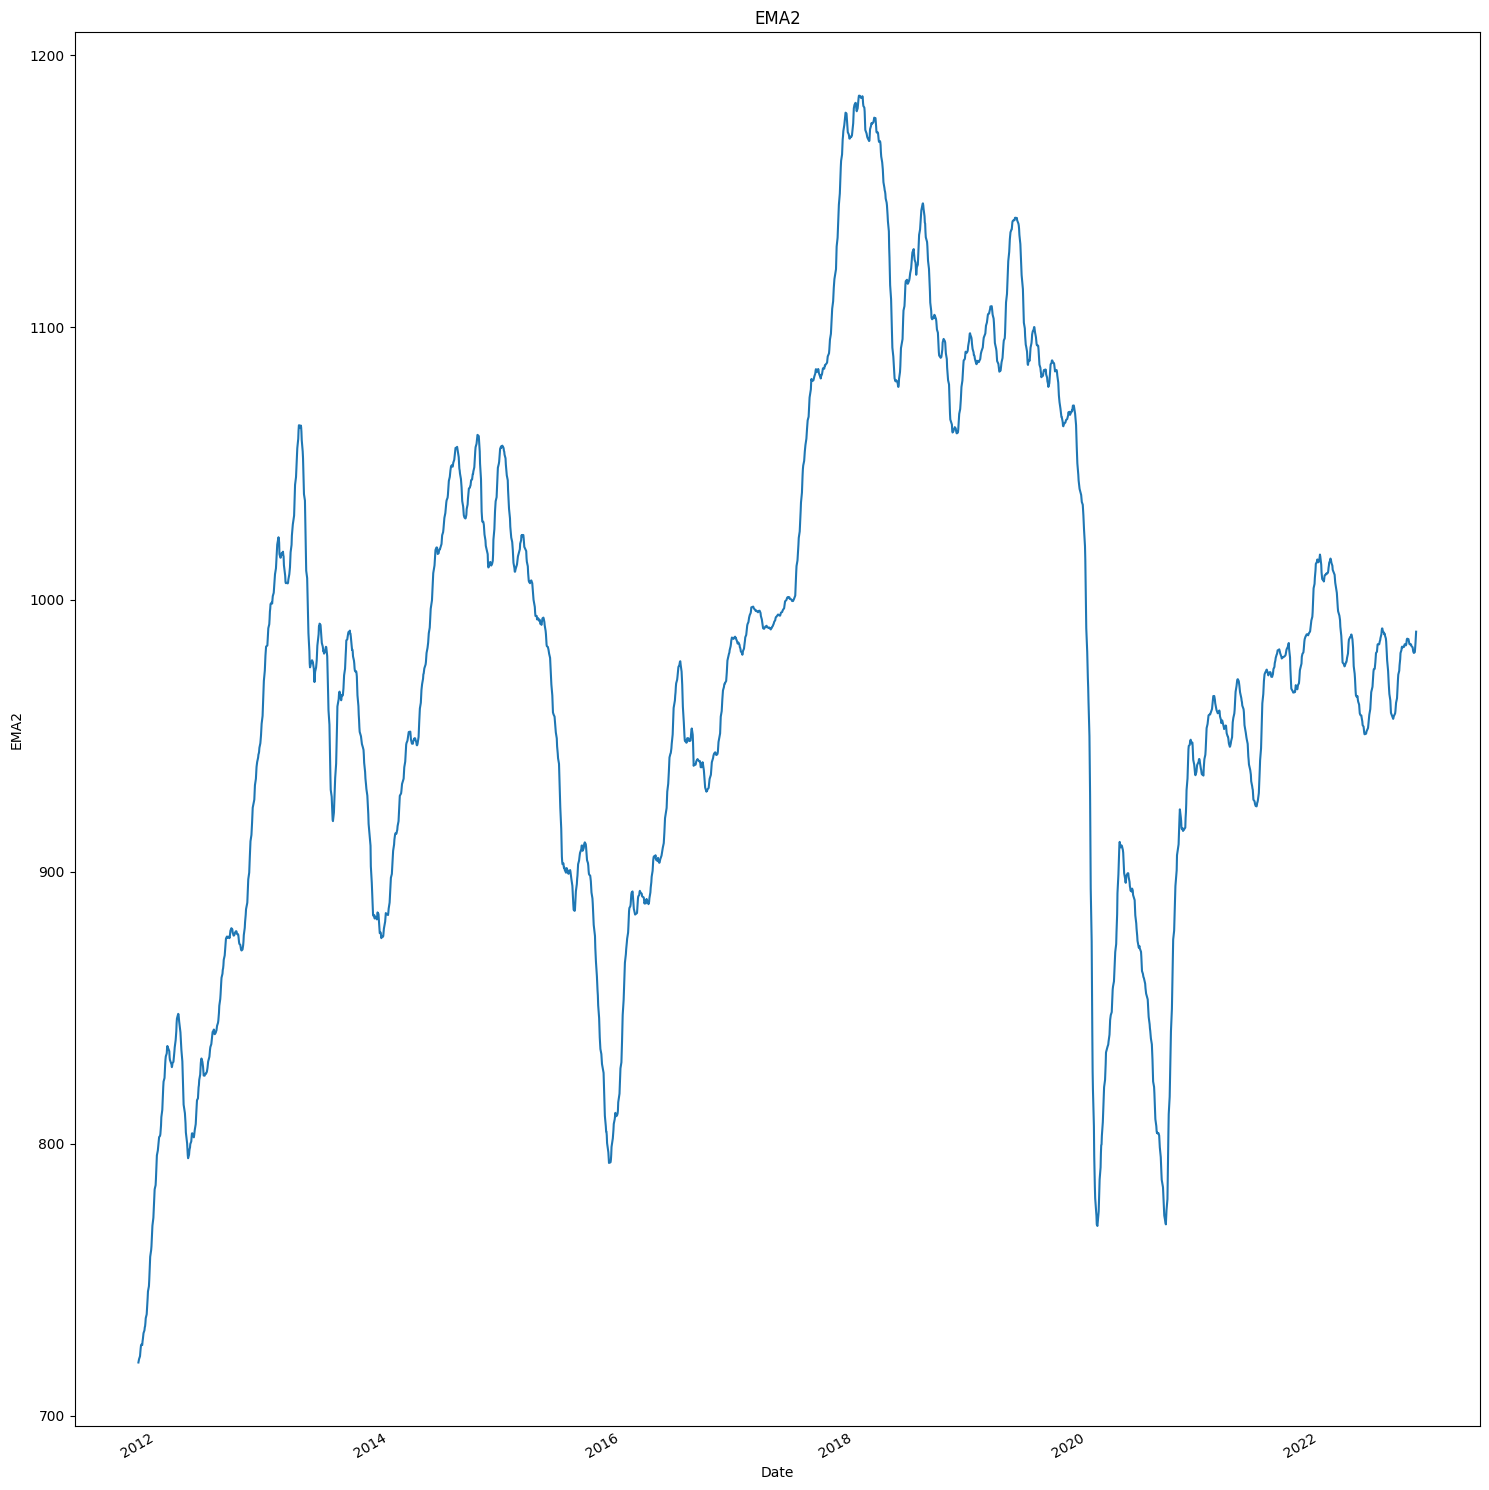

In [112]:
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [113]:
# Indexing Batches
df_train = df.sort_values(by=[date_col]).copy()
df_train.shape

(2680, 1)

In [114]:
def prepare_data(df):

    # List of considered Features
    FEATURES = feature_cols

    print(f'FEATURE LIST To Predict {prediction_col}')
    print([f for f in FEATURES])

    #Create the dataset with features and filter the data to the list of FEATURES"
    df_filter = df[FEATURES]
    
    print("Convert the data to numpy values")
    np_filter_unscaled = np.array(df_filter)
    np_filter_unscaled = np.reshape(np_filter_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)
    
    np_c_unscaled = np.array(df[prediction_col]).reshape(-1, 1)
    print(np_c_unscaled.shape)
    
    return np_filter_unscaled, np_c_unscaled

np_filter_unscaled, np_c_unscaled = prepare_data(df_train)   


print("Feature Data",np_filter_unscaled.shape)
print(np_filter_unscaled[:3])
print("Prediction Data",np_c_unscaled.shape)
print(np_c_unscaled[:3])

FEATURE LIST To Predict EMA2
['EMA2']
Convert the data to numpy values
(2680, 1)
(2680, 1)
Feature Data (2680, 1)
[[719.58]
 [720.3 ]
 [720.81]]
Prediction Data (2680, 1)
[[719.58]
 [720.3 ]
 [720.81]]


In [115]:
print(f"{input_sequence_length} = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction")
print(f"{output_sequence_length} = The output sequence length is the number of steps that the neural network predicts")

#How much ratio to split
index_Close = df_train.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Close}")

# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_filter_unscaled.shape[0] * train_ratio)
print(f"{train_ratio} = {train_data_length} Split the training data into train and train data sets")

60 = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction
10 = The output sequence length is the number of steps that the neural network predicts
Prediction Index = 0
0.8 = 2144 Split the training data into train and train data sets


In [116]:
print("Creating a separate scaler that works on a single column for scaling predictions")
print("Scale each feature to a range between 0 and 1")
scaler_train = MinMaxScaler()
print("Create a separate scaler for a single column")
scaler_pred = MinMaxScaler()


if split_way==1:
    print("Way#1 scale entire data and split data")   
    
    np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)
    
    print("All Data scaled for creating train and test data")    
    print(np_scaled.shape,np_scaled_c.shape)
    print(np_scaled_c[:5],np_scaled_c[:5])
    
    # Create the training and test data
    train_data =np_scaled[0:train_data_length, :]
    test_data = np_scaled[train_data_length - input_sequence_length:, :]

else:
    print("#Way#2 split data and apply  only train to scale")
    
    train_data = np_filter_unscaled[0:train_data_length, :]
    test_data = np_filter_unscaled[train_data_length - input_sequence_length:, :]

    np_PredictVal_unScaled=np_c_unscaled[0:train_data_length]
    
    print("Train Data to be scaled") 
    print(train_data.shape,np_PredictVal_unScaled.shape)
    print(train_data[:5],np_PredictVal_unScaled[:5])
    
    train_data=scaler_train.fit_transform(train_data)
    test_data=scaler_train.transform(test_data)
    
    print(f"For predict test that take the past {input_sequence_length} train value to predict the first test value")
    np_scaled=scaler_train.transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_PredictVal_unScaled)
    
    print("Predict val data(Scaled from Train data")
    print(np_scaled_c.shape)
    print(np_scaled_c[:3])
print("=========================================")       
print("Scaled data completely")
print("train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:3])
print(test_data[:3])



Creating a separate scaler that works on a single column for scaling predictions
Scale each feature to a range between 0 and 1
Create a separate scaler for a single column
Way#1 scale entire data and split data
All Data scaled for creating train and test data
(2680, 1) (2680, 1)
[[0.        ]
 [0.00154642]
 [0.00264181]
 [0.00496145]
 [0.00829056]] [[0.        ]
 [0.00154642]
 [0.00264181]
 [0.00496145]
 [0.00829056]]
Scaled data completely
train and test data
(2144, 1) (596, 1)
[[0.        ]
 [0.00154642]
 [0.00264181]]
[[0.38332009]
 [0.37936811]
 [0.37586718]]


In [117]:
print("The RNN needs data with the format of [samples, time steps, features]")
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation ,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

The RNN needs data with the format of [samples, time steps, features]


In [118]:
print(f"Here, we create {len(train_data)} samples, input_sequence_length time steps per sample, and f features")

print("Generate training data and test data")
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print("The shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



Here, we create 2144 samples, input_sequence_length time steps per sample, and f features
Generate training data and test data
The shapes: the result is: (rows, training_sequence, features) (prediction value, )
(2074, 60, 1) (2074, 10)
(526, 60, 1) (526, 10)


# Step #4 Model Training

# Paramterter Network

In [119]:
# Configure the neural network model
# tf.random.set_seed(7)

model = Sequential()
n_output_neurons = output_sequence_length
  
inputshape_Timestamps= x_train.shape[1]
no_feature=x_train.shape[2]
#x_train.shape[1] * x_train.shape[2]
neuron_number =inputshape_Timestamps * no_feature

step_neuron=int(neuron_number)
max_neuron=int(step_neuron*5)
print(f"Train Row : {x_train.shape[0]} to predict future {n_output_neurons}")
print(f"Total NN : {neuron_number}= {inputshape_Timestamps}(backward step) x {no_feature} (features) with step up {step_neuron} until {max_neuron}")
    

min_drop=0.1
max_drop=0.3
step_drop=0.1

ratio_traial_max=0.7  # 0.6/0.7

neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

allPosComb=len(neuron_list)*len(drop_list)
print(f"{neuron_list} and {drop_list}")
print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")

nMax_trials=int(allPosComb*ratio_traial_max)
nExecutions_per_trial=3

print("MAx run :" ,nMax_trials , "each trail run to essemble ",nExecutions_per_trial)

Train Row : 2074 to predict future 10
Total NN : 60= 60(backward step) x 1 (features) with step up 60 until 300
[60, 120, 180, 240, 300] and [0.1 0.2 0.3]
all combination : 5 x 3 = 15
MAx run : 10 each trail run to essemble  3


# NetWork Architeture Model Design

In [120]:
# Way one layer
def build_model_way(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))

    model.add(Dense(n_output_neurons))

    model.compile(optimizer="adam", loss=my_model_loss,metrics = my_model_metrics)
    return model

In [121]:
buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"multivar_myway_{buildtime}"
print(project_model)


t_Start=time.time()

print(f"Start tund at {datetime.now()}")

multivar_myway_060123_1350
Start tund at 2023-01-06 13:50:00.388344


In [122]:
early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)

tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        my_way_build_model,
        objective=my_obj_tune,
        max_trials=nMax_trials,
        seed=seed,
        executions_per_trial=nExecutions_per_trial,
        directory=f"{tune_folder}/",
        project_name= project_model
   
        )
tuner.search(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs,
                        validation_data=(x_test, y_test),
                        shuffle=False,verbose=1,callbacks=[early_stop])



Trial 2 Complete [00h 17m 03s]
mse: 0.0017070387257263064

Best mse So Far: 0.0017070387257263064
Total elapsed time: 00h 30m 54s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
300               |120               |input_unit
0.3               |0.3               |Dropout_rate

Epoch 1/100
65/65 [==============================] - 21s 271ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 2/100
65/65 [==============================] - 17s 259ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/100
65/65 [==============================] - 17s 259ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/100
65/65 [==============================] - 17s 257ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 5/100
65/65 [==============================] - 17s 257ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 6/100
65/65 [

KeyboardInterrupt: 

In [ ]:
print("Space to search")
tuner.search_space_summary()
print(f"Suumary of {nMax_trials}")
tuner.results_summary()

In [ ]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

In [97]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model=tuner.get_best_models(num_models=1)[0]

print(best_hps.values)

model.summary()

{'input_unit': 30, 'Dropout_rate': 0.1}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model = tuner.hypermodel.build(best_hps)

# Training the TUNED Model All Data

In [20]:
print(f"Training the TUNE Model")
t_Start=time.time()
print(datetime.now())

if n_early==0:

 history = model.fit(x_train, y_train, 
                batch_size=n_batch_size,
                epochs=n_epochs,
                shuffle=False,
                validation_data=(x_test, y_test),
                verbose=2
               )
else:
    early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
                    
    history = model.fit(x_train, y_train, 
                    batch_size=n_batch_size, 
                    epochs=n_epochs,
                    shuffle=False,
                    validation_data=(x_test, y_test),
                    verbose=2,callbacks=[early_stop]
                   )
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training the TUNE Model
2023-01-06 01:37:37.389150
Epoch 1/10
10/10 - 8s - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0133 - val_mse: 0.0133 - 8s/epoch - 780ms/step
Epoch 2/10
10/10 - 0s - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0129 - val_mse: 0.0129 - 328ms/epoch - 33ms/step
Epoch 3/10
10/10 - 0s - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0127 - val_mse: 0.0127 - 334ms/epoch - 33ms/step
Epoch 4/10
10/10 - 0s - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0124 - val_mse: 0.0124 - 365ms/epoch - 37ms/step
Epoch 5/10
10/10 - 0s - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0120 - val_mse: 0.0120 - 348ms/epoch - 35ms/step
Epoch 6/10
10/10 - 0s - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0120 - val_mse: 0.0120 - 357ms/epoch - 36ms/step
Epoch 7/10
10/10 - 0s - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0114 - val_mse: 0.0114 - 360ms/epoch - 36ms/step
Epoch 8/10
10/10 - 0s - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0113 - val_mse: 0.0113 - 404ms/epoch - 40ms/step
Epoch 9/10
10/10 - 0s - loss: 0.0194 - 

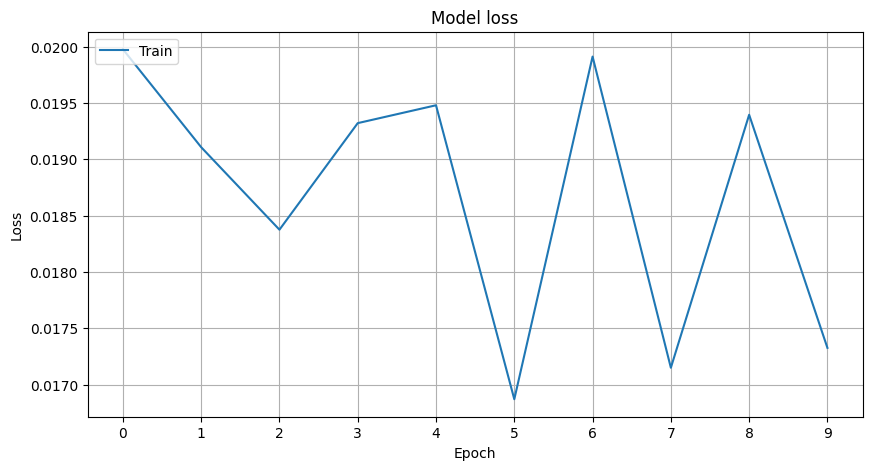

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(n_epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

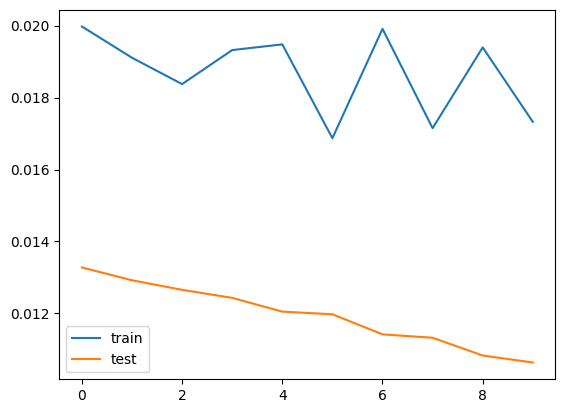

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [29]:
# import shap

# # we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model, x_train)
# shap_values = explainer.shap_values(x_test)

# Step #5 Evaluate Model Performance

In [98]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
print(y_pred_scaled.shape)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
print(y_pred.shape)
print(y_test_unscaled.shape)

2/2 [==============================] - 1s 4ms/step
(47, 1)
(47, 1)
(47, 1)


In [99]:
RMSE = math.sqrt( mean_squared_error(y_test_unscaled, y_pred))
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')


# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')




Root MEAN Square Error(RMSE): 2.23
Mean Absolute Error (MAE): 1.71
Median Absolute Error (MAE): 1.71
Mean Absolute Percentage Error (MAPE): 0.18 %
Median Absolute Percentage Error (MDAPE): 0.14 %


# Plot Multiple Forcast (Most Complex Step)

In [100]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Close])\
    .rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = stockname + "_stock_price_quotes")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)



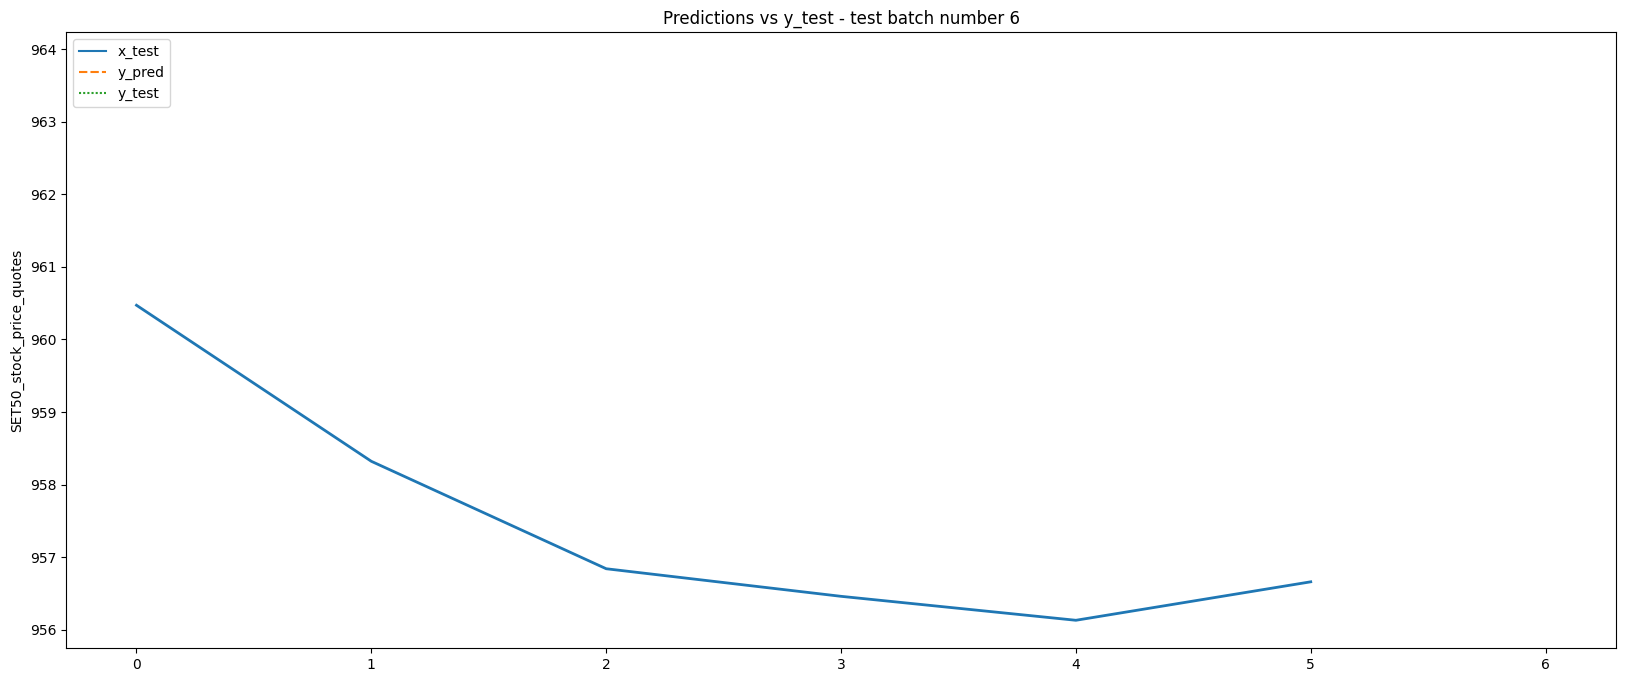

In [101]:
# Creates a linechart for a specific test batch_number and corresponding test predictions

x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(i, x_test, y_test, y_pred)
title = f"Predictions vs y_test - test batch number {input_sequence_length}"
plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title) 

# Step #6 Create a new Forecast

In [102]:
x_test_latest_batch = np_scaled[-(input_sequence_length+1):-1,:].reshape(1,input_sequence_length,len(feature_cols))
print(f"{x_test_latest_batch.shape} is the latest input batch from the test dataset, which is contains the price values for the last {input_sequence_length} trading days")

    
x_test_latest_batch

(1, 6, 1) is the latest input batch from the test dataset, which is contains the price values for the last 6 trading days


array([[[0.45578437],
        [0.45245306],
        [0.45699576],
        [0.479255  ],
        [0.50575409],
        [0.54376136]]])

In [103]:
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)
print(f"Predict on the inverse transformed batch {y_pred_unscaled.shape}")
print(y_pred_unscaled)

1/1 [==============================] - 0s 25ms/step
Predict on the inverse transformed batch (1, 1)
[[983.1034]]


In [104]:
print("Prepare the data and plot the input data and the predictions")
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
print(f"X-Test= {x_test_unscaled_df.shape}")
print(f"Y-Test= {y_test_unscaled_df.shape}")

# print(x_test_unscaled_df.tail(len(y_test_unscaled_df)))
# print(y_test_unscaled_df.tail(len(y_test_unscaled_df)))

Prepare the data and plot the input data and the predictions
X-Test= (6, 1)
Y-Test= (1, 1)


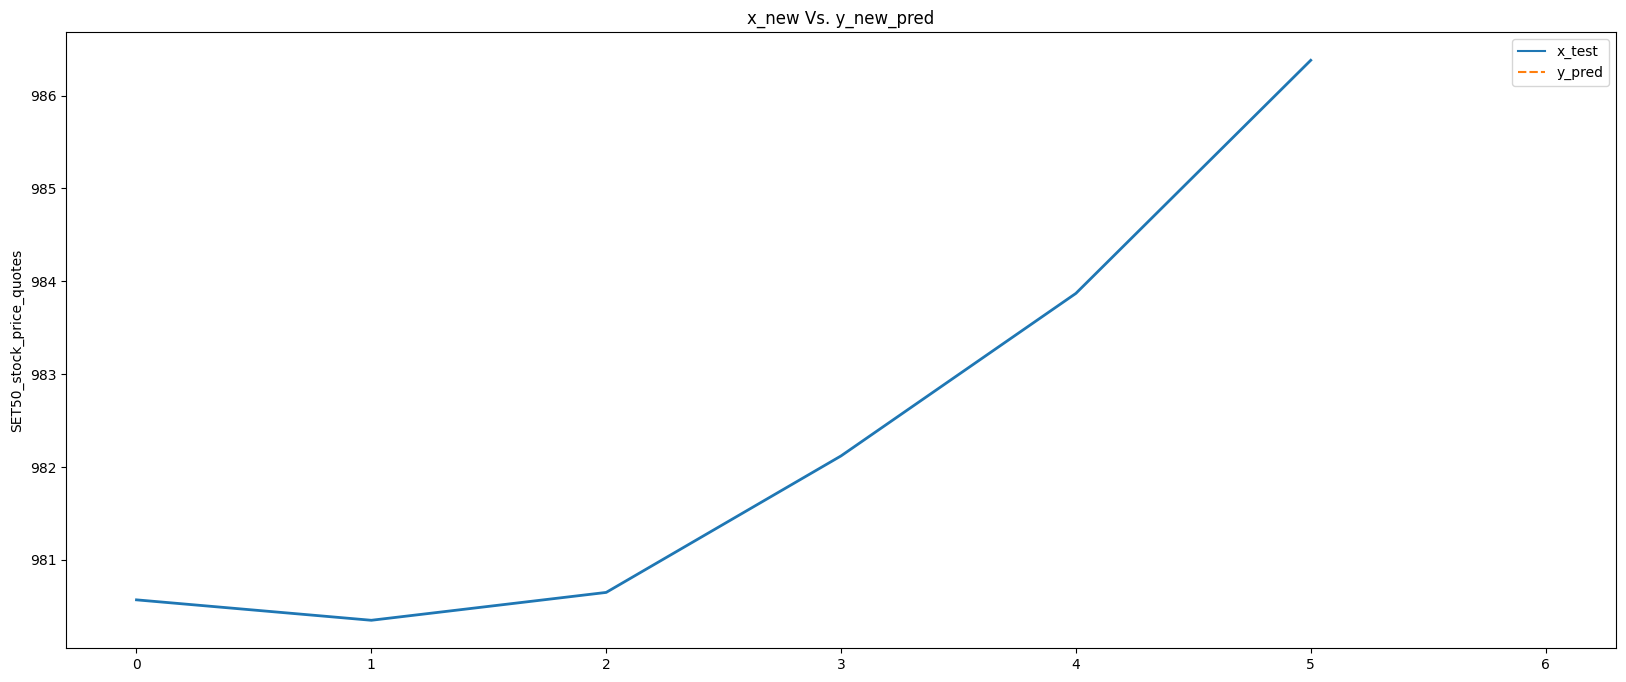

In [105]:
plot_multi_test_forecast(x_test_unscaled_df, '',y_test_unscaled_df, "x_new Vs. y_new_pred")